<a href="https://colab.research.google.com/github/lagom-QB/M11/blob/master/Practice_9_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SSD train

# keywords: dataloader, mAP, balancing

In [0]:
import torch.nn as nn
import torch
import numpy as np
import math
from typing import List, Tuple
from torch.nn import Conv2d, Sequential, ModuleList, BatchNorm2d
import torch.nn.functional as F
import itertools

from torchvision import transforms
import cv2
import types
from numpy import random
import pathlib
import pandas as pd
import copy
import os


from collections import namedtuple
GraphPath = namedtuple("GraphPath", ['s0', 'name', 's1'])

###Let's create 2 class SSD model, using pretrain from the previous class.

In [0]:
def conv_bn(inp, oup, stride, use_batch_norm=True, onnx_compatible=False):
    ReLU = nn.ReLU if onnx_compatible else nn.ReLU6

    if use_batch_norm:
        return nn.Sequential(
            nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
            nn.BatchNorm2d(oup),
            ReLU(inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
            ReLU(inplace=True)
        )


def conv_1x1_bn(inp, oup, use_batch_norm=True, onnx_compatible=False):
    ReLU = nn.ReLU if onnx_compatible else nn.ReLU6
    if use_batch_norm:
        return nn.Sequential(
            nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
            ReLU(inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
            ReLU(inplace=True)
        )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, use_batch_norm=True, onnx_compatible=False):
        super(InvertedResidual, self).__init__()
        ReLU = nn.ReLU if onnx_compatible else nn.ReLU6

        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            if use_batch_norm:
                self.conv = nn.Sequential(
                    # dw
                    nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                    nn.BatchNorm2d(hidden_dim),
                    ReLU(inplace=True),
                    # pw-linear
                    nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                    nn.BatchNorm2d(oup),
                )
            else:
                self.conv = nn.Sequential(
                    # dw
                    nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                    ReLU(inplace=True),
                    # pw-linear
                    nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                )
        else:
            if use_batch_norm:
                self.conv = nn.Sequential(
                    # pw
                    nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                    nn.BatchNorm2d(hidden_dim),
                    ReLU(inplace=True),
                    # dw
                    nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                    nn.BatchNorm2d(hidden_dim),
                    ReLU(inplace=True),
                    # pw-linear
                    nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                    nn.BatchNorm2d(oup),
                )
            else:
                self.conv = nn.Sequential(
                    # pw
                    nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                    ReLU(inplace=True),
                    # dw
                    nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                    ReLU(inplace=True),
                    # pw-linear
                    nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

def SeparableConv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, onnx_compatible=False):
    ReLU = nn.ReLU if onnx_compatible else nn.ReLU6
    return Sequential(
        Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size,
               groups=in_channels, stride=stride, padding=padding),
        BatchNorm2d(in_channels),
        ReLU(),
        Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
    )

class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1., dropout_ratio=0.2,
                 use_batch_norm=True, onnx_compatible=False):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2, onnx_compatible=onnx_compatible)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s,
                                               expand_ratio=t, use_batch_norm=use_batch_norm,
                                               onnx_compatible=onnx_compatible))
                else:
                    self.features.append(block(input_channel, output_channel, 1,
                                               expand_ratio=t, use_batch_norm=use_batch_norm,
                                               onnx_compatible=onnx_compatible))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel,
                                         use_batch_norm=use_batch_norm, onnx_compatible=onnx_compatible))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(self.last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [0]:
def iou_of(box1, box2):
    """
    Returns the IoU of two bounding boxes 
    """
    #Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[...,0], box1[...,1], box1[...,2], box1[...,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[...,0], box2[...,1], box2[...,2], box2[...,3]

    #get the corrdinates of the intersection rectangle
    inter_rect_x1 =  torch.max(b1_x1, b2_x1)
    inter_rect_y1 =  torch.max(b1_y1, b2_y1)
    inter_rect_x2 =  torch.min(b1_x2, b2_x2)
    inter_rect_y2 =  torch.min(b1_y2, b2_y2)

    #Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
 
    #Union Area
    b1_area = (b1_x2 - b1_x1 + 1)*(b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1)*(b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area)
    return iou

def hard_negative_mining(loss, labels, neg_pos_ratio):
    """
    It used to suppress the presence of a large number of negative prediction.
    It works on image level not batch level.
    For any example/image, it keeps all the positive predictions and
     cut the number of negative predictions to make sure the ratio
     between the negative examples and positive examples is no more
     the given ratio for an image.
    Args:
        loss (N, num_priors): the loss for each example.
        labels (N, num_priors): the labels.
        neg_pos_ratio:  the ratio between the negative examples and positive examples.
    """
    pos_mask = labels > 0
    num_pos = pos_mask.long().sum(dim=1, keepdim=True)
    num_neg = num_pos * neg_pos_ratio

    loss[pos_mask] = -math.inf
    _, indexes = loss.sort(dim=1, descending=True)
    _, orders = indexes.sort(dim=1)
    neg_mask = orders < num_neg
    return pos_mask | neg_mask
def convert_boxes_to_locations(center_form_boxes, center_form_priors, center_variance, size_variance):
    # priors can have one dimension less
    if center_form_priors.dim() + 1 == center_form_boxes.dim():
        center_form_priors = center_form_priors.unsqueeze(0)
    return torch.cat([
        (center_form_boxes[..., :2] - center_form_priors[..., :2]) / center_form_priors[..., 2:] / center_variance,
        torch.log(center_form_boxes[..., 2:] / center_form_priors[..., 2:]) / size_variance
    ], dim=center_form_boxes.dim() - 1)

def corner_form_to_center_form(boxes):
    return torch.cat([
        (boxes[..., :2] + boxes[..., 2:]) / 2,
         boxes[..., 2:] - boxes[..., :2]
    ], boxes.dim() - 1)

def assign_priors(gt_boxes, gt_labels, corner_form_priors,
                  iou_threshold):
    """Assign ground truth boxes and targets to priors.
    Args:
        gt_boxes (num_targets, 4): ground truth boxes.
        gt_labels (num_targets): labels of targets.
        priors (num_priors, 4): corner form priors
    Returns:
        boxes (num_priors, 4): real values for priors.
        labels (num_priros): labels for priors.
    """
    # size: num_priors x num_targets
    ious = iou_of(gt_boxes.unsqueeze(0), corner_form_priors.unsqueeze(1))
    # size: num_priors
    best_target_per_prior, best_target_per_prior_index = ious.max(1)
    # size: num_targets
    best_prior_per_target, best_prior_per_target_index = ious.max(0)

    for target_index, prior_index in enumerate(best_prior_per_target_index):
        best_target_per_prior_index[prior_index] = target_index
    # 2.0 is used to make sure every target has a prior assigned
    best_target_per_prior.index_fill_(0, best_prior_per_target_index, 2)
    # size: num_priors
    labels = gt_labels[best_target_per_prior_index]
    labels[best_target_per_prior < iou_threshold] = 0  # the backgournd id
    boxes = gt_boxes[best_target_per_prior_index]
    return boxes, labels
    
def convert_locations_to_boxes(locations, priors, center_variance,
                               size_variance):
    """Convert regressional location results of SSD into boxes in the form of (center_x, center_y, h, w).
    The conversion:
        $$predicted\_center * center_variance = \frac {real\_center - prior\_center} {prior\_hw}$$
        $$exp(predicted\_hw * size_variance) = \frac {real\_hw} {prior\_hw}$$
    We do it in the inverse direction here.
    Args:
        locations (batch_size, num_priors, 4): the regression output of SSD. It will contain the outputs as well.
        priors (num_priors, 4) or (batch_size/1, num_priors, 4): prior boxes.
        center_variance: a float used to change the scale of center.
        size_variance: a float used to change of scale of size.
    Returns:
        boxes:  priors: [[center_x, center_y, h, w]]. All the values
            are relative to the image size.
    """
    # priors can have one dimension less.
    if priors.dim() + 1 == locations.dim():
        priors = priors.unsqueeze(0)
    return torch.cat([
        locations[..., :2] * center_variance * priors[..., 2:] + priors[..., :2],
        torch.exp(locations[..., 2:] * size_variance) * priors[..., 2:]
    ], dim=locations.dim() - 1)
def center_form_to_corner_form(locations):
    return torch.cat([locations[..., :2] - locations[..., 2:]/2,
                     locations[..., :2] + locations[..., 2:]/2], locations.dim() - 1)

In [0]:
class SSD(nn.Module):
    def __init__(self, num_classes: int, base_net: nn.ModuleList, source_layer_indexes: List[int],
                 extras: nn.ModuleList, classification_headers: nn.ModuleList,
                 regression_headers: nn.ModuleList, is_test=False, config=None, device=None):

        super(SSD, self).__init__()

        self.num_classes = num_classes
        self.base_net = base_net
        self.source_layer_indexes = source_layer_indexes
        self.extras = extras
        self.classification_headers = classification_headers
        self.regression_headers = regression_headers
        self.is_test = is_test
        self.config = config

        # register layers in source_layer_indexes by adding them to a module list
        self.source_layer_add_ons = nn.ModuleList([t[1] for t in source_layer_indexes
                                                   if isinstance(t, tuple) and not isinstance(t, GraphPath)])
        if device:
            self.device = device
        else:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if is_test:
            self.config = config
            self.priors = config.priors.to(self.device)
            
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        confidences = []
        locations = []
        start_layer_index = 0
        header_index = 0
        for end_layer_index in self.source_layer_indexes:
            if isinstance(end_layer_index, GraphPath):
                path = end_layer_index
                end_layer_index = end_layer_index.s0
                added_layer = None
            elif isinstance(end_layer_index, tuple):
                added_layer = end_layer_index[1]
                end_layer_index = end_layer_index[0]
                path = None
            else:
                added_layer = None
                path = None
            for layer in self.base_net[start_layer_index: end_layer_index]:
                x = layer(x)
            if added_layer:
                y = added_layer(x)
            else:
                y = x
            if path:
                sub = getattr(self.base_net[end_layer_index], path.name)
                for layer in sub[:path.s1]:
                    x = layer(x)
                y = x
                for layer in sub[path.s1:]:
                    x = layer(x)
                end_layer_index += 1
            start_layer_index = end_layer_index
            confidence, location = self.compute_header(header_index, y)
            header_index += 1
            confidences.append(confidence)
            locations.append(location)

        for layer in self.base_net[end_layer_index:]:
            x = layer(x)

        for layer in self.extras:
            x = layer(x)
            confidence, location = self.compute_header(header_index, x)
            header_index += 1
            confidences.append(confidence)
            locations.append(location)

        confidences = torch.cat(confidences, 1)
        locations = torch.cat(locations, 1)
        
        if self.is_test:
            confidences = F.softmax(confidences, dim=2)
            boxes = convert_locations_to_boxes(
                locations, self.priors, self.config.center_variance, self.config.size_variance
            )
            boxes = center_form_to_corner_form(boxes)
            return confidences, boxes
        else:
            return confidences, locations

    def compute_header(self, i, x):
        confidence = self.classification_headers[i](x)
        confidence = confidence.permute(0, 2, 3, 1).contiguous()
        confidence = confidence.view(confidence.size(0), -1, self.num_classes)

        location = self.regression_headers[i](x)
        location = location.permute(0, 2, 3, 1).contiguous()
        location = location.view(location.size(0), -1, 4)

        return confidence, location

    def init_from_base_net(self, model):
        self.base_net.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage), strict=True)
        self.source_layer_add_ons.apply(_xavier_init_)
        self.extras.apply(_xavier_init_)
        self.classification_headers.apply(_xavier_init_)
        self.regression_headers.apply(_xavier_init_)

    def init_from_pretrained_ssd(self, model):
        state_dict = torch.load(model, map_location=lambda storage, loc: storage)
        state_dict = {k: v for k, v in state_dict.items() if not (k.startswith("classification_headers") or k.startswith("regression_headers"))}
        model_dict = self.state_dict()
        model_dict.update(state_dict)
        self.load_state_dict(model_dict)
        self.classification_headers.apply(_xavier_init_)
        self.regression_headers.apply(_xavier_init_)

    def init(self):
        self.base_net.apply(_xavier_init_)
        self.source_layer_add_ons.apply(_xavier_init_)
        self.extras.apply(_xavier_init_)
        self.classification_headers.apply(_xavier_init_)
        self.regression_headers.apply(_xavier_init_)

    def load(self, model):
        self.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage))

    def save(self, model_path):
        torch.save(self.state_dict(), model_path)

In [0]:
SSDBoxSizes = namedtuple('SSDBoxSizes', ['min', 'max'])

SSDSpec = namedtuple('SSDSpec', ['feature_map_size', 'shrinkage', 'box_sizes', 'aspect_ratios'])


def generate_ssd_priors(specs: List[SSDSpec], image_size, clamp=True) -> torch.Tensor:
    """Generate SSD Prior Boxes.
    It returns the center, height and width of the priors. The values are relative to the image size
    Args:
        specs: SSDSpecs about the shapes of sizes of prior boxes. i.e.
            specs = [
                SSDSpec(38, 8, SSDBoxSizes(30, 60), [2]),
                SSDSpec(19, 16, SSDBoxSizes(60, 111), [2, 3]),
                SSDSpec(10, 32, SSDBoxSizes(111, 162), [2, 3]),
                SSDSpec(5, 64, SSDBoxSizes(162, 213), [2, 3]),
                SSDSpec(3, 100, SSDBoxSizes(213, 264), [2]),
                SSDSpec(1, 300, SSDBoxSizes(264, 315), [2])
            ]
        image_size: image size.
        clamp: if true, clamp the values to make fall between [0.0, 1.0]
    Returns:
        priors (num_priors, 4): The prior boxes represented as [[center_x, center_y, w, h]]. All the values
            are relative to the image size.
    """
    priors = []
    for spec in specs:
        scale = image_size / spec.shrinkage
        for j, i in itertools.product(range(spec.feature_map_size), repeat=2):
            x_center = (i + 0.5) / scale
            y_center = (j + 0.5) / scale

            # small sized square box
            size = spec.box_sizes.min
            h = w = size / image_size
            priors.append([
                x_center,
                y_center,
                w,
                h
            ])

            # big sized square box
            size = math.sqrt(spec.box_sizes.max * spec.box_sizes.min)
            h = w = size / image_size
            priors.append([
                x_center,
                y_center,
                w,
                h
            ])

            # change h/w ratio of the small sized box
            size = spec.box_sizes.min
            h = w = size / image_size
            for ratio in spec.aspect_ratios:
                ratio = math.sqrt(ratio)
                priors.append([
                    x_center,
                    y_center,
                    w * ratio,
                    h / ratio
                ])
                priors.append([
                    x_center,
                    y_center,
                    w / ratio,
                    h * ratio
                ])

    priors = torch.tensor(priors)
    if clamp:
        torch.clamp(priors, 0.0, 1.0, out=priors)
    return priors

class config: 
  image_size = 300
  image_mean = np.array([127, 127, 127])  # RGB layout
  image_std = 128.0
  iou_threshold = 0.45
  center_variance = 0.1
  size_variance = 0.2

  specs = [
      SSDSpec(19, 16, SSDBoxSizes(60, 105), [2, 3]),
      SSDSpec(10, 32, SSDBoxSizes(105, 150), [2, 3]),
      SSDSpec(5, 64, SSDBoxSizes(150, 195), [2, 3]),
      SSDSpec(3, 100, SSDBoxSizes(195, 240), [2, 3]),
      SSDSpec(2, 150, SSDBoxSizes(240, 285), [2, 3]),
      SSDSpec(1, 300, SSDBoxSizes(285, 330), [2, 3])
  ]
  priors = generate_ssd_priors(specs, image_size)

def create_mobilenetv2_ssd_lite(num_classes, width_mult=1.0, use_batch_norm=True, onnx_compatible=False, is_test=False):
    base_net = MobileNetV2(width_mult=width_mult, use_batch_norm=use_batch_norm,
                           onnx_compatible=onnx_compatible).features

    source_layer_indexes = [
        GraphPath(14, 'conv', 3),
        19,
    ]
    extras = ModuleList([
        InvertedResidual(1280, 512, stride=2, expand_ratio=0.2),
        InvertedResidual(512, 256, stride=2, expand_ratio=0.25),
        InvertedResidual(256, 256, stride=2, expand_ratio=0.5),
        InvertedResidual(256, 64, stride=2, expand_ratio=0.25)
    ])

    regression_headers = ModuleList([
        SeparableConv2d(in_channels=round(576 * width_mult), out_channels=6 * 4,
                        kernel_size=3, padding=1, onnx_compatible=False),
        SeparableConv2d(in_channels=1280, out_channels=6 * 4, kernel_size=3, padding=1, onnx_compatible=False),
        SeparableConv2d(in_channels=512, out_channels=6 * 4, kernel_size=3, padding=1, onnx_compatible=False),
        SeparableConv2d(in_channels=256, out_channels=6 * 4, kernel_size=3, padding=1, onnx_compatible=False),
        SeparableConv2d(in_channels=256, out_channels=6 * 4, kernel_size=3, padding=1, onnx_compatible=False),
        Conv2d(in_channels=64, out_channels=6 * 4, kernel_size=1),
    ])

    classification_headers = ModuleList([
        SeparableConv2d(in_channels=round(576 * width_mult), out_channels=6 * num_classes, kernel_size=3, padding=1),
        SeparableConv2d(in_channels=1280, out_channels=6 * num_classes, kernel_size=3, padding=1),
        SeparableConv2d(in_channels=512, out_channels=6 * num_classes, kernel_size=3, padding=1),
        SeparableConv2d(in_channels=256, out_channels=6 * num_classes, kernel_size=3, padding=1),
        SeparableConv2d(in_channels=256, out_channels=6 * num_classes, kernel_size=3, padding=1),
        Conv2d(in_channels=64, out_channels=6 * num_classes, kernel_size=1),
    ])
    return SSD(num_classes, base_net, source_layer_indexes,
               extras, classification_headers, regression_headers, is_test=is_test, config=config)

In [0]:
net = create_mobilenetv2_ssd_lite(21, is_test=True)

In [7]:
! wget https://storage.googleapis.com/models-hao/mb2-ssd-lite-mp-0_686.pth

--2020-06-02 10:55:58--  https://storage.googleapis.com/models-hao/mb2-ssd-lite-mp-0_686.pth
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13829316 (13M) [application/octet-stream]
Saving to: ‘mb2-ssd-lite-mp-0_686.pth’

mb2-ssd-lite-mp-0_6 100%[===================>]  13.19M  --.-KB/s    in 0.1s    

2020-06-02 10:55:59 (95.2 MB/s) - ‘mb2-ssd-lite-mp-0_686.pth’ saved [13829316/13829316]



In [0]:
net.load("mb2-ssd-lite-mp-0_686.pth")

In [9]:
net

SSD(
  (base_net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Co

In [10]:
net.eval()

SSD(
  (base_net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Co

In [0]:
net = net.to('cuda:0')
boxes, scores = net.forward(torch.ones(1,3, 300,300).cuda())

In [19]:
scores.shape

torch.Size([1, 3000, 4])

In [20]:
boxes.shape

torch.Size([1, 3000, 21])

In [0]:
state = {
    "base_net": net.base_net.state_dict(),
    "extras": net.extras.state_dict(),
}

In [0]:
net = create_mobilenetv2_ssd_lite(3)

In [23]:
net

SSD(
  (base_net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Co

In [24]:
net.base_net.load_state_dict(state["base_net"])
net.extras.load_state_dict(state["extras"])

<All keys matched successfully>

###Let's create a dataset, which will be a subset of open images dataset.

In [25]:
!git clone https://github.com/EscVM/OIDv4_ToolKit.git

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 422, done.
remote: Total 422 (delta 0), reused 0 (delta 0), pack-reused 422
Receiving objects: 100% (422/422), 34.08 MiB | 10.02 MiB/s, done.
Resolving deltas: 100% (146/146), done.


###Let's install awscli (we will need it to download the data)

In [26]:
!pip install --upgrade --user awscli

     |████████████████████████████████| 3.1MB 2.8MB/s 
     |████████████████████████████████| 6.2MB 29.2MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [0]:
import os
os.environ['PATH'] += ":/root/.local/bin"

###Let's create gun dataset for detection. 

>This can take a while to download. You may perefer to store images on your google drive, so you won't have to repeat the process in case of disconnection. In this case it may be benefitial to copy them to the local drive, before you start the training.

In [28]:
!(cd OIDv4_ToolKit && python main.py downloader --classes Bicycle --type_csv train --limit 500)


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading Gun.
   [ERROR] | Missing the class-descriptions-boxable.csv file.
[DOWNLOAD] | Do you want to download the missing file? [Y/n] y
...145%, 0 MB, 42661 KB/s, 0 seconds passed
[DOWNLOAD] | File clas

###Let's create a dataset for our data.

In [0]:
class OpenImagesDataset:

    def __init__(self, root,
                 transform=None, target_transform=None,
                 dataset_type="train", balance_data=False, classes_filter=None,
                 check_existance=True):
        self.root = pathlib.Path(root)
        self.transform = transform
        self.target_transform = target_transform
        self.dataset_type = dataset_type.lower()
        self.check_existance = check_existance

        self.data, self.class_names, self.class_dict = self._read_data(classes_filter)
        self.balance_data = balance_data
        self.min_image_num = -1
        if self.balance_data:
            print("balance data")
            self.data = self._balance_data()
        print('map ids')
        self.ids = [info['image_id'] for info in self.data]

        self.class_stat = None

    def _getitem(self, index):
        image_info = self.data[index]
        image = self._read_image(image_info['class'], image_info['image_id'])
        # duplicate boxes to prevent corruption of dataset
        boxes = copy.copy(image_info['boxes'])
        boxes[:, 0] *= image.shape[1]
        boxes[:, 1] *= image.shape[0]
        boxes[:, 2] *= image.shape[1]
        boxes[:, 3] *= image.shape[0]
        # duplicate labels to prevent corruption of dataset
        labels = copy.copy(image_info['labels'])
        if self.transform:
            image, boxes, labels = self.transform(image, boxes, labels)
        if self.target_transform:
            boxes, labels = self.target_transform(boxes, labels)
        return image_info['image_id'], image, boxes, labels

    def __getitem__(self, index):
        _, image, boxes, labels = self._getitem(index)
        return image, boxes, labels

    def get_annotation(self, index):
        image_id, image, boxes, labels = self._getitem(index)
        is_difficult = np.zeros(boxes.shape[0], dtype=np.uint8)
        return image_id, (boxes, labels, is_difficult)

    def get_image(self, index):
        image_info = self.data[index]
        image = self._read_image(image_info['class'], image_info['image_id'])
        if self.transform:
            image, _, _ = self.transform(image, image_info['boxes'], image_info['labels'])
        return image

    def _read_data(self, classes_filter=None):
        print("load annotations")
        annotation_file = f"{self.root}/csv_folder/{self.dataset_type}-annotations-bbox.csv"
        annotations = pd.read_csv(annotation_file)

        print("load classes")
        classes_file = f"{self.root}/csv_folder/class-descriptions-boxable.csv"
        classes = pd.read_csv(classes_file, header=None, names=['LabelName', 'ClassName'])
        class_data = {}
        filtered_classes = classes[classes.LabelName.isin(annotations.LabelName.unique())]
        for index, row in filtered_classes.iterrows():
          if classes_filter is None or row['ClassName'] in classes_filter:
            class_data[row['LabelName']] = row['ClassName']
  
        print("assign class")
        annotations['ClassName'] = annotations.LabelName.map(lambda x: class_data[x] if x in class_data else 'NONE' )

        print("remove unused classes")
        annotations = annotations.drop(annotations[annotations.ClassName == 'NONE'].index)

        class_names = ['BACKGROUND'] + sorted(list(annotations['ClassName'].unique()))
        class_dict = {class_name: i for i, class_name in enumerate(class_names)}
        data = []

        print("aggregate image info")
        for image_id, group in annotations.groupby("ImageID"):
            clazz = [name for name in group["ClassName"]][0]
            fpath = self.root / "Dataset" / self.dataset_type / clazz / f"{image_id}.jpg"
            if self.check_existance and not os.path.exists(fpath):
                continue
            boxes = group.loc[:, ["XMin", "YMin", "XMax", "YMax"]].values.astype(np.float32)
            # make labels 64 bits to satisfy the cross_entropy function
            labels = np.array([class_dict[name] for name in group["ClassName"]], dtype='int64')
            data.append({
                'image_id': image_id,
                'boxes': boxes,
                'class': clazz,
                'labels': labels,
            })
        return data, class_names, class_dict

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.class_stat is None:
            self.class_stat = {name: 0 for name in self.class_names[1:]}
            for example in self.data:
                for class_index in example['labels']:
                    class_name = self.class_names[class_index]
                    self.class_stat[class_name] += 1
        content = ["Dataset Summary:"
                   f"Number of Images: {len(self.data)}",
                   f"Minimum Number of Images for a Class: {self.min_image_num}",
                   "Label Distribution:"]
        for class_name, num in self.class_stat.items():
            content.append(f"\t{class_name}: {num}")
        return "\n".join(content)

    def _read_image(self, clazz, image_id):
        image_file = self.root / "Dataset" / self.dataset_type / clazz / f"{image_id}.jpg"
        image = cv2.imread(str(image_file))
        if image is None:
          print("INAVLID IMAGE", image_file)
        if image.shape[2] == 1:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _balance_data(self):
        label_image_indexes = [set() for _ in range(len(self.class_names))]
        for i, image in enumerate(self.data):
            for label_id in image['labels']:
                label_image_indexes[label_id].add(i)
        label_stat = [len(s) for s in label_image_indexes]
        self.min_image_num = min(label_stat[1:])
        sample_image_indexes = set()
        for image_indexes in label_image_indexes[1:]:
            image_indexes = np.array(list(image_indexes))
            sub = np.random.permutation(image_indexes)[:self.min_image_num]
            sample_image_indexes.update(sub)
        sample_data = [self.data[i] for i in sample_image_indexes]
        return sample_data

###Let's define some transformations for augmentation

In [0]:
def intersect(box_a, box_b):
    max_xy = np.minimum(box_a[:, 2:], box_b[2:])
    min_xy = np.maximum(box_a[:, :2], box_b[:2])
    inter = np.clip((max_xy - min_xy), a_min=0, a_max=np.inf)
    return inter[:, 0] * inter[:, 1]

def jaccard_numpy(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: Multiple bounding boxes, Shape: [num_boxes,4]
        box_b: Single bounding box, Shape: [4]
    Return:
        jaccard overlap: Shape: [box_a.shape[0], box_a.shape[1]]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1]))  # [A,B]
    area_b = ((box_b[2]-box_b[0]) *
              (box_b[3]-box_b[1]))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


class Compose(object):
    """Composes several augmentations together.
    Args:
        transforms (List[Transform]): list of transforms to compose.
    Example:
        >>> augmentations.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, boxes=None, labels=None):
        for t in self.transforms:
            img, boxes, labels = t(img, boxes, labels)
        return img, boxes, labels

class Lambda(object):
    """Applies a lambda as a transform."""

    def __init__(self, lambd):
        assert isinstance(lambd, types.LambdaType)
        self.lambd = lambd

    def __call__(self, img, boxes=None, labels=None):
        return self.lambd(img, boxes, labels)

class ConvertFromInts(object):
    def __call__(self, image, boxes=None, labels=None):
        return image.astype(np.float32), boxes, labels

class SubtractMeans(object):
    def __init__(self, mean):
        self.mean = np.array(mean, dtype=np.float32)

    def __call__(self, image, boxes=None, labels=None):
        image = image.astype(np.float32)
        image -= self.mean
        return image.astype(np.float32), boxes, labels

class ToAbsoluteCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        height, width, channels = image.shape
        boxes[:, 0] *= width
        boxes[:, 2] *= width
        boxes[:, 1] *= height
        boxes[:, 3] *= height

        return image, boxes, labels

class ToPercentCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        height, width, channels = image.shape
        boxes[:, 0] /= width
        boxes[:, 2] /= width
        boxes[:, 1] /= height
        boxes[:, 3] /= height

        return image, boxes, labels

class Resize(object):
    def __init__(self, size=300):
        self.size = size

    def __call__(self, image, boxes=None, labels=None):
        image = cv2.resize(image, (self.size,
                                 self.size))
        return image, boxes, labels

class RandomSaturation(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 1] *= random.uniform(self.lower, self.upper)

        return image, boxes, labels

class RandomHue(object):
    def __init__(self, delta=18.0):
        assert delta >= 0.0 and delta <= 360.0
        self.delta = delta

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 0] += random.uniform(-self.delta, self.delta)
            image[:, :, 0][image[:, :, 0] > 360.0] -= 360.0
            image[:, :, 0][image[:, :, 0] < 0.0] += 360.0
        return image, boxes, labels

class RandomLightingNoise(object):
    def __init__(self):
        self.perms = ((0, 1, 2), (0, 2, 1),
                      (1, 0, 2), (1, 2, 0),
                      (2, 0, 1), (2, 1, 0))

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            swap = self.perms[random.randint(len(self.perms))]
            shuffle = SwapChannels(swap)  # shuffle channels
            image = shuffle(image)
        return image, boxes, labels

class ConvertColor(object):
    def __init__(self, current, transform):
        self.transform = transform
        self.current = current

    def __call__(self, image, boxes=None, labels=None):
        if self.current == 'BGR' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.current == 'RGB' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif self.current == 'BGR' and self.transform == 'RGB':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif self.current == 'HSV' and self.transform == 'BGR':
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        elif self.current == 'HSV' and self.transform == "RGB":
            image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
        else:
            raise NotImplementedError
        return image, boxes, labels

class RandomContrast(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    # expects float image
    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            alpha = random.uniform(self.lower, self.upper)
            image *= alpha
        return image, boxes, labels

class RandomBrightness(object):
    def __init__(self, delta=32):
        assert delta >= 0.0
        assert delta <= 255.0
        self.delta = delta

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            delta = random.uniform(-self.delta, self.delta)
            image += delta
        return image, boxes, labels

class ToCV2Image(object):
    def __call__(self, tensor, boxes=None, labels=None):
        return tensor.cpu().numpy().astype(np.float32).transpose((1, 2, 0)), boxes, labels

class ToTensor(object):
    def __call__(self, cvimage, boxes=None, labels=None):
        return torch.from_numpy(cvimage.astype(np.float32)).permute(2, 0, 1), boxes, labels

class RandomSampleCrop(object):
    """Crop
    Arguments:
        img (Image): the image being input during training
        boxes (Tensor): the original bounding boxes in pt form
        labels (Tensor): the class labels for each bbox
        mode (float tuple): the min and max jaccard overlaps
    Return:
        (img, boxes, classes)
            img (Image): the cropped image
            boxes (Tensor): the adjusted bounding boxes in pt form
            labels (Tensor): the class labels for each bbox
    """
    def __init__(self):
        self.sample_options = (
            # using entire original input image
            None,
            # sample a patch s.t. MIN jaccard w/ obj in .1,.3,.4,.7,.9
            (0.1, None),
            (0.3, None),
            (0.7, None),
            (0.9, None),
            # randomly sample a patch
            (None, None),
        )

    def __call__(self, image, boxes=None, labels=None):
        height, width, _ = image.shape
        while True:
            # randomly choose a mode
            mode = random.choice(self.sample_options)
            if mode is None:
                return image, boxes, labels

            min_iou, max_iou = mode
            if min_iou is None:
                min_iou = float('-inf')
            if max_iou is None:
                max_iou = float('inf')

            # max trails (50)
            for _ in range(50):
                current_image = image

                w = random.uniform(0.3 * width, width)
                h = random.uniform(0.3 * height, height)

                # aspect ratio constraint b/t .5 & 2
                if h / w < 0.5 or h / w > 2:
                    continue

                left = random.uniform(width - w)
                top = random.uniform(height - h)

                # convert to integer rect x1,y1,x2,y2
                rect = np.array([int(left), int(top), int(left+w), int(top+h)])

                # calculate IoU (jaccard overlap) b/t the cropped and gt boxes
                overlap = jaccard_numpy(boxes, rect)

                # is min and max overlap constraint satisfied? if not try again
                if overlap.min() < min_iou and max_iou < overlap.max():
                    continue

                # cut the crop from the image
                current_image = current_image[rect[1]:rect[3], rect[0]:rect[2],
                                              :]

                # keep overlap with gt box IF center in sampled patch
                centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0

                # mask in all gt boxes that above and to the left of centers
                m1 = (rect[0] < centers[:, 0]) * (rect[1] < centers[:, 1])

                # mask in all gt boxes that under and to the right of centers
                m2 = (rect[2] > centers[:, 0]) * (rect[3] > centers[:, 1])

                # mask in that both m1 and m2 are true
                mask = m1 * m2

                # have any valid boxes? try again if not
                if not mask.any():
                    continue

                # take only matching gt boxes
                current_boxes = boxes[mask, :].copy()

                # take only matching gt labels
                current_labels = labels[mask]

                # should we use the box left and top corner or the crop's
                current_boxes[:, :2] = np.maximum(current_boxes[:, :2],
                                                  rect[:2])
                # adjust to crop (by substracting crop's left,top)
                current_boxes[:, :2] -= rect[:2]

                current_boxes[:, 2:] = np.minimum(current_boxes[:, 2:],
                                                  rect[2:])
                # adjust to crop (by substracting crop's left,top)
                current_boxes[:, 2:] -= rect[:2]

                return current_image, current_boxes, current_labels

class Expand(object):
    def __init__(self, mean):
        self.mean = mean

    def __call__(self, image, boxes, labels):
        if random.randint(2):
            return image, boxes, labels

        height, width, depth = image.shape
        ratio = random.uniform(1, 4)
        left = random.uniform(0, width*ratio - width)
        top = random.uniform(0, height*ratio - height)

        expand_image = np.zeros(
            (int(height*ratio), int(width*ratio), depth),
            dtype=image.dtype)
        expand_image[:, :, :] = self.mean
        expand_image[int(top):int(top + height),
                     int(left):int(left + width)] = image
        image = expand_image

        boxes = boxes.copy()
        boxes[:, :2] += (int(left), int(top))
        boxes[:, 2:] += (int(left), int(top))

        return image, boxes, labels

class RandomMirror(object):
    def __call__(self, image, boxes, classes):
        _, width, _ = image.shape
        if random.randint(2):
            image = image[:, ::-1]
            boxes = boxes.copy()
            boxes[:, 0::2] = width - boxes[:, 2::-2]
        return image, boxes, classes

class SwapChannels(object):
    """Transforms a tensorized image by swapping the channels in the order
     specified in the swap tuple.
    Args:
        swaps (int triple): final order of channels
            eg: (2, 1, 0)
    """

    def __init__(self, swaps):
        self.swaps = swaps

    def __call__(self, image):
        """
        Args:
            image (Tensor): image tensor to be transformed
        Return:
            a tensor with channels swapped according to swap
        """
        # if torch.is_tensor(image):
        #     image = image.data.cpu().numpy()
        # else:
        #     image = np.array(image)
        image = image[:, :, self.swaps]
        return image

class PhotometricDistort(object):
    def __init__(self):
        self.pd = [
            RandomContrast(),  # RGB
            ConvertColor(current="RGB", transform='HSV'),  # HSV
            RandomSaturation(),  # HSV
            RandomHue(),  # HSV
            ConvertColor(current='HSV', transform='RGB'),  # RGB
            RandomContrast()  # RGB
        ]
        self.rand_brightness = RandomBrightness()
        self.rand_light_noise = RandomLightingNoise()

    def __call__(self, image, boxes, labels):
        im = image.copy()
        im, boxes, labels = self.rand_brightness(im, boxes, labels)
        if random.randint(2):
            distort = Compose(self.pd[:-1])
        else:
            distort = Compose(self.pd[1:])
        im, boxes, labels = distort(im, boxes, labels)
        return self.rand_light_noise(im, boxes, labels)

###Let's define augmentations for training data.

In [0]:
class TrainAugmentation:
    def __init__(self, size, mean=0, std=1.0):
        """
        Args:
            size: the size the of final image.
            mean: mean pixel value per channel.
        """
        self.mean = mean
        self.size = size
        self.augment = Compose([
            ConvertFromInts(),
            PhotometricDistort(),
            Expand(self.mean),
            RandomSampleCrop(),
            RandomMirror(),
            ToPercentCoords(),
            Resize(self.size),
            SubtractMeans(self.mean),
            lambda img, boxes=None, labels=None: (img / std, boxes, labels),
            ToTensor(),
        ])

    def __call__(self, img, boxes, labels):

        return self.augment(img, boxes, labels)

###Let's define convertion for labels (from bboxes coners to center form and SSD internal representation)

In [0]:
class MatchPrior(object):
    def __init__(self, center_form_priors, center_variance, size_variance, iou_threshold):
        self.center_form_priors = center_form_priors
        self.corner_form_priors = center_form_to_corner_form(center_form_priors)
        self.center_variance = center_variance
        self.size_variance = size_variance
        self.iou_threshold = iou_threshold

    def __call__(self, gt_boxes, gt_labels):
        if type(gt_boxes) is np.ndarray:
            gt_boxes = torch.from_numpy(gt_boxes)
        if type(gt_labels) is np.ndarray:
            gt_labels = torch.from_numpy(gt_labels)
        boxes, labels = assign_priors(gt_boxes, gt_labels,
                                      self.corner_form_priors, self.iou_threshold)
        boxes = corner_form_to_center_form(boxes)
        locations = convert_boxes_to_locations(boxes, self.center_form_priors, self.center_variance, self.size_variance)
        return locations, labels

In [0]:
class TestTransform:
    def __init__(self, size, mean=0.0, std=1.0):
        self.transform = Compose([
            ToPercentCoords(),
            Resize(size),
            SubtractMeans(mean),
            lambda img, boxes=None, labels=None: (img / std, boxes, labels),
            ToTensor(),
        ])

    def __call__(self, image, boxes, labels):
        return self.transform(image, boxes, labels)

In [0]:
image_size = 300
image_mean = np.array([127, 127, 127]) 
image_std = 128.0

In [0]:
train_transforms = TrainAugmentation(image_size, image_mean, image_std)

In [0]:
test_transforms = TestTransform(image_size, image_mean, image_std)

In [0]:
target_transform = MatchPrior(config.priors, config.center_variance,
                              config.size_variance, 0.5)

In [38]:
!(cd OIDv4_ToolKit && python main.py downloader --classes Cat Dog --type_csv train --limit 500)


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading Cat.
   [ERROR] | Missing the train-annotations-bbox.csv file.
[DOWNLOAD] | Do you want to download the missing file? [Y/n] y
...100%, 1138 MB, 41197 KB/s, 28 seconds passed
[DOWNLOAD] | File trai

###Loss function

In [0]:
class MultiboxLoss(nn.Module):
    def __init__(self, priors, iou_threshold, neg_pos_ratio,
                 center_variance, size_variance, device):
        """Implement SSD Multibox Loss.
        Basically, Multibox loss combines classification loss
         and Smooth L1 regression loss.
        """
        super(MultiboxLoss, self).__init__()
        self.iou_threshold = iou_threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.center_variance = center_variance
        self.size_variance = size_variance
        self.priors = priors
        self.priors.to(device)

    def forward(self, confidence, predicted_locations, labels, gt_locations):
        """Compute classification loss and smooth l1 loss.
        Args:
            confidence (batch_size, num_priors, num_classes): class predictions.
            locations (batch_size, num_priors, 4): predicted locations.
            labels (batch_size, num_priors): real labels of all the priors.
            boxes (batch_size, num_priors, 4): real boxes corresponding all the priors.
        """
        num_classes = confidence.size(2)
        with torch.no_grad():
            # derived from cross_entropy=sum(log(p))
            loss = -F.log_softmax(confidence, dim=2)[:, :, 0]
            mask = hard_negative_mining(loss, labels, self.neg_pos_ratio)

        confidence = confidence[mask, :]
        classification_loss = F.cross_entropy(confidence.reshape(-1, num_classes), labels[mask], size_average=False)
        pos_mask = labels > 0
        predicted_locations = predicted_locations[pos_mask, :].reshape(-1, 4)
        gt_locations = gt_locations[pos_mask, :].reshape(-1, 4)
        smooth_l1_loss = F.smooth_l1_loss(predicted_locations, gt_locations, size_average=False)
        num_pos = gt_locations.size(0)
        return smooth_l1_loss/num_pos, classification_loss/num_pos

In [0]:
loss = MultiboxLoss(config.priors, iou_threshold=0.5, neg_pos_ratio=3,
                    center_variance=0.1, size_variance=0.2, device=torch.device("cuda:0"))

Evaluation:

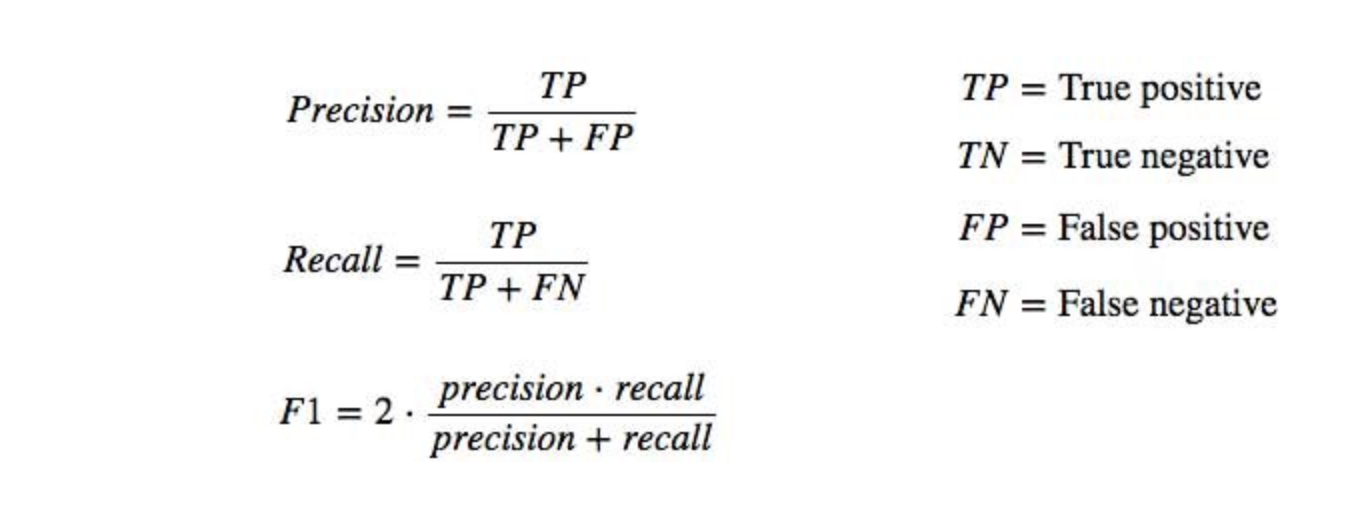

Prediction is TP if it overlaps with correct prediction (IOU > threshold, usually 0.5) and the label matches label of correct prediction. To avoid division by zero, usually we add `eps` to true positive.

You can easily achive precision or recall equal to 1 (How?).

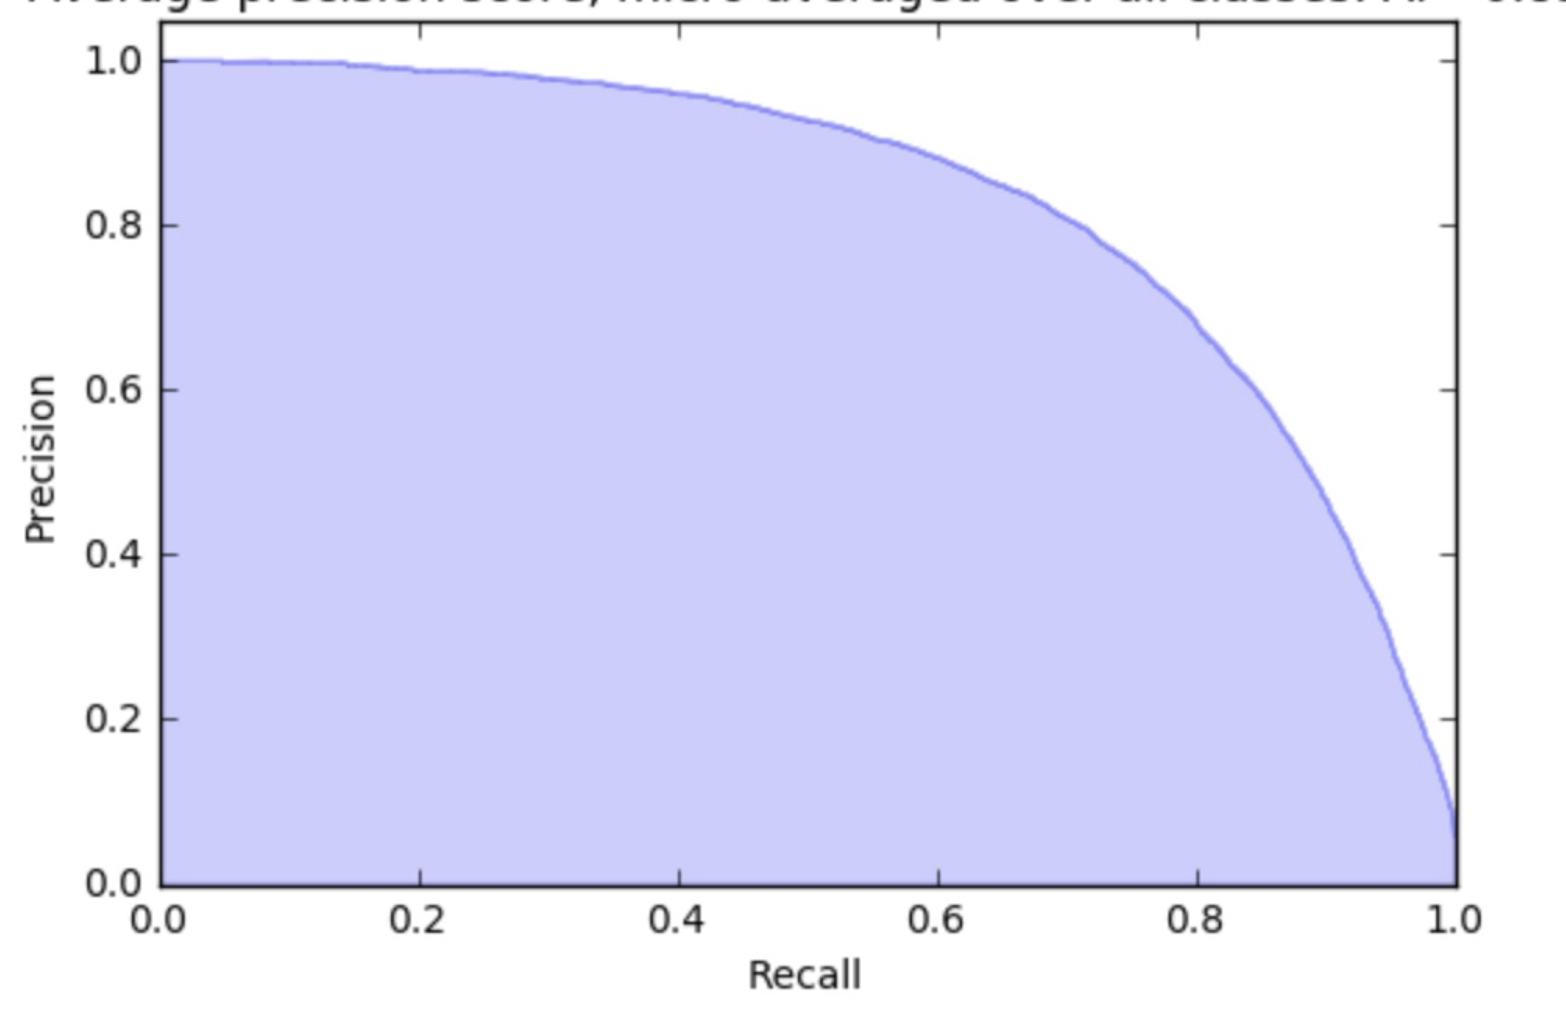

By warying threshold, we can select on which point of this plot we will end (select precision/recall tradeoff). As precision and recall impowtance can differ between applications, detection systems are often compare by the area below the ploat: mean average precision (mAP).

# Assignment

#1

##Download cat/dogs dataset from openimages (no more than 500 images each).

In [61]:
!(cd OIDv4_ToolKit && python main.py downloader --classes Cat Dog --type_csv train --limit 500)


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading Cat.

Cat
    [INFO] | Downloading train images.
    [INFO] | [INFO] Found 12516 online images for train.
    [INFO] | Limiting to 500 images.
    [INFO] | Download of 432 images in train.
100% 43

In [65]:
catdogtest_dataset = OpenImagesDataset("OIDv4_ToolKit/OID",
                            transform=test_transforms,
                            dataset_type="train", balance_data=True, classes_filter=['Cat', 'Dog'])

load annotations
load classes
assign class
remove unused classes
aggregate image info
balance data
map ids


In [66]:
catdogtrain_dataset = OpenImagesDataset("OIDv4_ToolKit/OID/",
                            transform=train_transforms, target_transform=target_transform,
                            dataset_type="train", balance_data=True, classes_filter=['Cat', 'Dog'])

load annotations
load classes
assign class
remove unused classes
aggregate image info
balance data
map ids


In [67]:
catdogtrain_dataset.get_image(2).unsqueeze(0).shape

torch.Size([1, 3, 300, 300])

In [68]:
catdogtest_dataset.get_image(232).shape

torch.Size([3, 300, 300])

In [0]:
path, image, boxes, labels = catdogtrain_dataset._getitem(0)

In [70]:
ann = catdogtrain_dataset.get_annotation(232)
ann

('053c0ac9bcd9c203', (tensor([[18.7728, 27.3455,  6.9579,  6.4561],
          [14.1909, 20.6713,  5.5589,  5.0570],
          [13.2744, 38.6724,  5.2251,  8.1890],
          ...,
          [-1.4570,  0.7358,  0.9001, -1.5911],
          [-0.9788,  1.3415, -1.0893,  1.4119],
          [-1.7845,  0.7358,  1.9137, -1.5911]]),
  tensor([0, 0, 0,  ..., 1, 1, 1]),
  array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)))

#2

##Calculate mAP of pretrained network on this images.



In [0]:
def prob_threshold(scores, boxes, threshold):
    indices = ((scores.max(dim=2).indices != 0) & (scores.max(dim=2).values > torch.tensor([threshold]))) # If the max tensor value is not zero, and the max score is greater than our threshold
   
    filter_ = [i for i,x in enumerate(indices[0]) if x]

    filtered_scores = scores[:, filter_]
    filtered_boxes  = boxes[:, filter_]

    return filtered_scores, filtered_boxes

def nms(bboxes, scores, iou_threshold):
    available = torch.tensor([True] * bboxes.shape[0])
    
    for x in range(len(bboxes)):
    
         for y in range(x+1, len(bboxes)):
    
            if available[y]== True and scores[x].argmax() == scores[y].argmax():  # If 02 consequent regions have equal probablities
    
                boxA = bboxes[x] 
                boxB = bboxes[y] 

                xA = max(boxA[0], boxB[0])
                yA = max(boxA[1], boxB[1])
                xB = min(boxA[2], boxB[2])
                yB = min(boxA[3], boxB[3])

                interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
                
                boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
                boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
                
                iou = interArea / float(boxAArea + boxBArea - interArea)
                
                if iou > iou_threshold:
                
                    if scores[x].max() > scores[y].max():
                        available[y] = False
                    else:
                        available[x] = False
                        break

    filters = [i for i,x in enumerate(available) if x]
    
    filtered_scores = scores[filters]
    filtered_boxes = bboxes[filters]
    
    return filtered_scores, filtered_boxes

In [0]:
image_ids, scores, boxes, images = [], [], [], []

model = create_mobilenetv2_ssd_lite(3)
model = model.to("cuda")

for index in range(len(catdogtest_dataset)):
    path, image, box, label = catdogtest_dataset._getitem(index)
    
    image_ids.append(path)
    images.append(image)
    boxes.append(box)
    scores.append(label)

for index in range(len(catdogtest_dataset)):
    with torch.no_grad():
        boxez, scorez = model.forward(torch.tensor(images[index].unsqueeze(0)).cuda())
        print(scorez,'\n', boxez)

In [0]:
precision = precision_score(cd_train_loader, 
                            cat_model.train(), 
                            average='micro')
print(precision)

recall = [4]
precision = [4]
mAP = calculate_meanAveargePrecision(recall, precision)

mAP

#3

###Choose any class and download corresponding dataset from openimages (about 1000 images, there may be not enough images for some classes).

In [0]:
!(cd OIDv4_ToolKit && python main.py downloader --classes Skull Human_eye --type_csv train --limit 1000)

#4

###Train ssd classifier to detect selectted classes.


In [0]:
# Define train test functions
def train(model, train_loader, optimizer, loss_function, epoch, writer):
    model.train()
    train_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        output = model(data)
        loss = loss_function(output, target)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    train_loss /= len(train_loader.dataset)

    writer.add_scalar("train_loss", train_loss, global_step=epoch)

def test(model, test_loader, loss_function, epoch, writer):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    writer.add_scalar("test_loss", test_loss, global_step=epoch)
    writer.add_scalar("accuracy", accuracy, global_step=epoch)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [0]:
%load_ext tensorboard

%tensorboard --logdir logs

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 12, 0.1, -1)
writer = SummaryWriter("logs/ass")

for epoch in range(1, 40):
    try:
        train(model, train_loader, optimizer, loss_function, epoch, writer)
        test(model, test_loader, loss_function, epoch, writer)
        scheduler.step()
    except KeyboardInterrupt:
        break
writer.close()

>  You may want to completely freeze pretrained layers (or train them with very small lr).

In [0]:
train_loader = OpenImagesDataset("OIDv4_ToolKit/OID/",
                            transform=train_transforms, 
                            target_transform=target_transform,
                            dataset_type="train", 
                            balance_data=True, 
                            classes_filter=['Skull', 'Human eye'])

test_loader = OpenImagesDataset("OIDv4_ToolKit/OID/",
                            transform=train_transforms, 
                            target_transform=target_transform,
                            dataset_type="test", 
                            balance_data=True, 
                            classes_filter=['Skull', 'Human eye'])

In [0]:
model = create_mobilenetv2_ssd_lite(21)

model.eval()

In [0]:
dataset.data

In [0]:
with torch.no_grad():
    scores, boxes = model.forward(dataset.class_names('Human eye'))

5. Download validation part for of openimages dataset for the choosen class and calculate mAP of your network. [1]

1. Download cat/dogs dataset from openimages (no more than 500 images each).[2]

2. Calculate mAP of pretrained network on this images. [3]

3. Choose any class and download corresponding dataset from openimages (about 1000 images, there may be not enough images for some classes).[1]

4. Train ssd classifier to detect selectted class. You may want to completely freeze pretrained layers (or train them with very small lr). [3]

5. Download validation part for of openimages dataset for the choosen class and calculate mAP of your network. [1]